In [1]:
import json
import os
import requests
BASE_URL = "http://127.0.0.1:8000"
file_path = 'c:/Users/wbrya/OneDrive/Documents/GitHub/ocr-inference-gpu/dataset/10k_tesla_3_pages.pdf'
def log(msg):
    print(f"\n{'='*40}\n{msg}\n{'='*40}")

with open(file_path, "rb") as f:
    filename = os.path.basename(file_path)
    files = {
        'file': (
            filename,
            f,
            'application/pdf'  # explicitly tell the server it's a PDF
        )
    }
    response = requests.post(f"{BASE_URL}/api/v1/ocr/process", files=files)
try:
    task_id = response.json().get("task_id")
except Exception as e:
    print("Status code:", response.status_code)
    print("Response text:", response.text)
    print("Error decoding JSON:", e)

In [3]:
import time
start = time.time()
for i in range(10):
    r = requests.get(f"{BASE_URL}/api/v1/ocr/results/{task_id}")
    # Handle HTTP errors
    if r.status_code != 200:
        log(f"[CLIENT] HTTP {r.status_code} error on attempt {i+1}: {r.text}")
        break
    try:
        data = r.json()
    except ValueError as e:
        log(f"[CLIENT] Invalid JSON on attempt {i+1}: status={r.status_code}, response={r.text}")
        time.sleep(2)
        continue
    status = data.get("status")
    pending_tasks = data.get("pending_tasks")
    log(f"[CLIENT] Poll Attempt {i+1}: Status = {status}, Pending Task = {pending_tasks}")
    if data.get("result"):
        log(f"[CLIENT] Result:\n{json.dumps(data, indent=2)}")
        break
    time.sleep(2)

print(f"time={time.time() - start}s")


[CLIENT] Poll Attempt 1: Status = SUCCESS, Pending Task = 0

[CLIENT] Result:
{
  "task_id": "514eb5c3-c226-40d1-bea1-aa225d61a95f",
  "status": "SUCCESS",
  "result": {
    "detections": [
      {
        "text": "UNITED STATES",
        "box": [
          [
            466.0,
            117.0
          ],
          [
            757.0,
            117.0
          ],
          [
            757.0,
            157.0
          ],
          [
            466.0,
            157.0
          ]
        ],
        "confidence": 0.9991229772567749,
        "page_number": 1
      },
      {
        "text": "SECURITIES AND EXCHANGE COMMISSION",
        "box": [
          [
            221.0,
            163.0
          ],
          [
            999.0,
            163.0
          ],
          [
            999.0,
            198.0
          ],
          [
            221.0,
            198.0
          ]
        ],
        "confidence": 0.9990208745002747,
        "page_number": 1
      },
    

In [4]:
!pip install matplotlib


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: C:\Users\wbrya\OneDrive\Documents\GitHub\ocr-inference\.venv\Scripts\python.exe -m pip install --upgrade pip


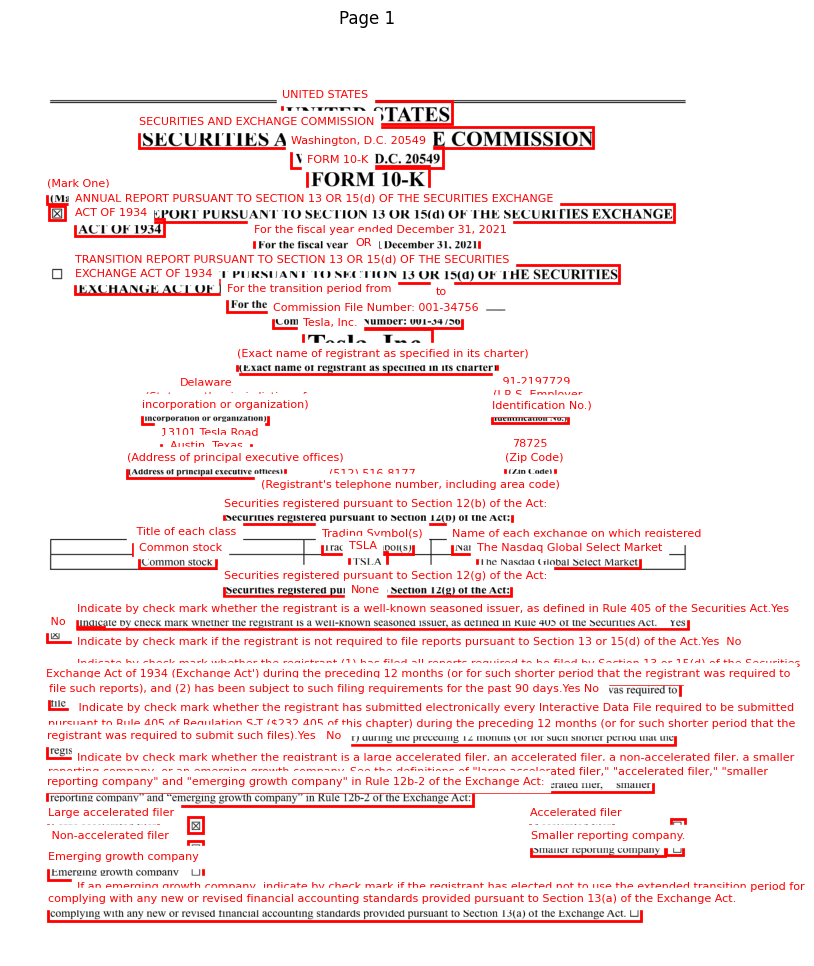

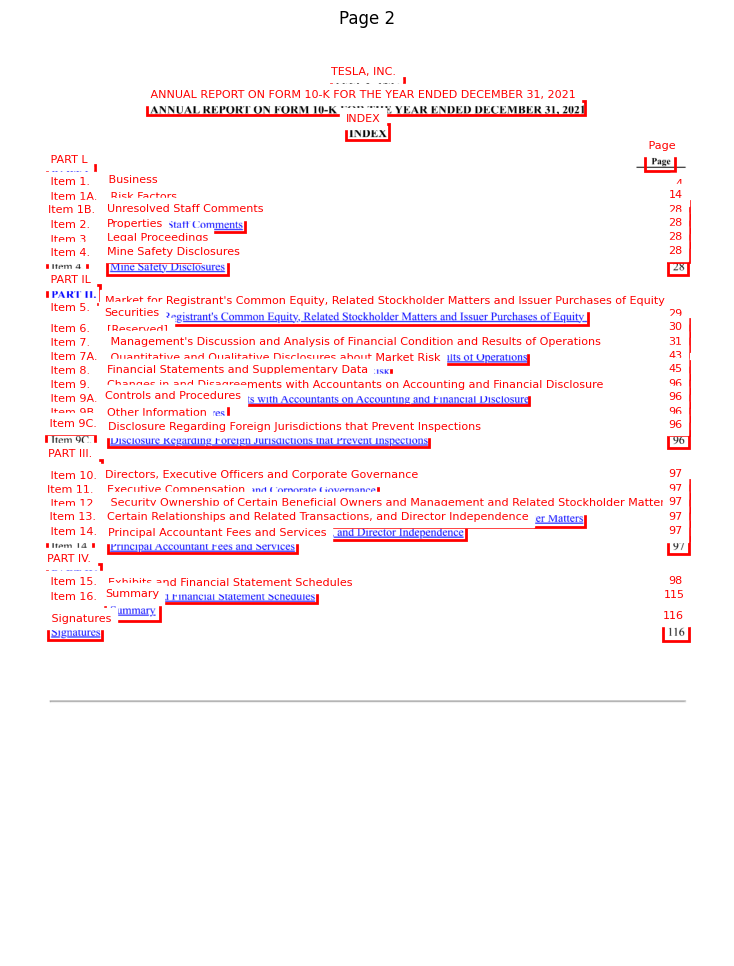

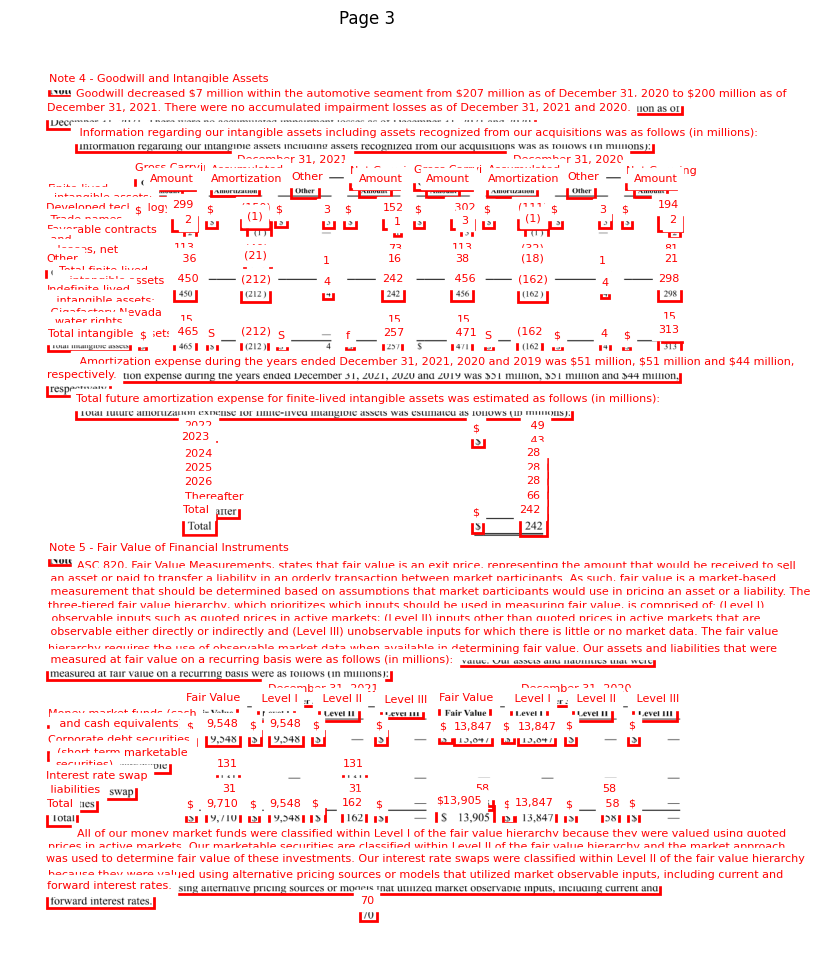

In [5]:
import io
import fitz  # PyMuPDF
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import defaultdict

# Helper function to render a PDF page as an image
def pdf_page_to_image(file_path, page_number=0, zoom=2):
    doc = fitz.open(file_path)
    try:
        page = doc.load_page(page_number)
        matrix = fitz.Matrix(zoom, zoom)
        pixmap = page.get_pixmap(matrix=matrix)
        image_data = pixmap.tobytes("png")
        image = Image.open(io.BytesIO(image_data))
    finally:
        doc.close()
    return image

# Open the PDF to get the number of pages
pdf_doc = fitz.open(file_path)
num_pages = pdf_doc.page_count
pdf_doc.close()

# Extract the detections array from the API response
all_items = data.get('result', {}).get('detections', [])

# Group bounding boxes by page_number (0-based index)
page_boxes = defaultdict(list)
for item in all_items:
    page_idx = item.get('page_number', 1) - 1  # Convert to 0-based
    page_boxes[page_idx].append(item)

# Loop through all pages and plot bounding boxes for each
for page_number in range(num_pages):
    img = pdf_page_to_image(file_path, page_number=page_number, zoom=2)
    fig, ax = plt.subplots(1, figsize=(12, 12))
    ax.imshow(img)
    # Draw bounding boxes for this page
    for item in page_boxes.get(page_number, []):
        box = item.get('box')
        if box and len(box) == 4:
            xs = [pt[0] for pt in box]
            ys = [pt[1] for pt in box]
            min_x, min_y = min(xs), min(ys)
            max_x, max_y = max(xs), max(ys)
            rect = patches.Rectangle((min_x, min_y), max_x - min_x, max_y - min_y, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            ax.text(min_x, min_y - 5, item.get('text', ''), color='red', fontsize=8, backgroundcolor='white')
    ax.set_title(f"Page {page_number + 1}")
    plt.axis('off')
    plt.show()